# GTHA housing market database
# OSEMN methodology Step 4: Model
# Clustering

Clustering (or cluster analysis) is a technique that allows us to find groups of similar objects, objects that are more related to each other than to objects in other groups. Examples of business-oriented applications of clustering include the grouping of documents, music, and movies by different topics, or finding customers that share similar interests based on common purchase behaviors as a basis for recommendation engines.

This notebook uses two feature sets to test clustering algorithms: all features and top 11 selected features and with missing past/future xy sales filled with mean future/past xy sales + binary encoded top 10 land use categories.

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
random_state = 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

from time import time

sns.set()

In [3]:
import sys

sys.path.append('../../../../src')

from io_utils import df_from_csv

In [4]:
# path to save plots
plot_save_path = os.path.join('results', 'clustering')
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

## Load Teranet data

In [5]:
data_path = '../../../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['4_Teranet_lu_predict_3c.csv',
 'parcel16_epoi13.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 'GTAjoinedLanduseSales']

In [6]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict_3c.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 93.86 seconds
with 5,188,513 rows
and 79 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change

## Load Census data

In [7]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'taz_level_vars',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [8]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.18 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [9]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [10]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.01 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [11]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 54.03 seconds (0.90 minutes)
with 5,188,513 rows
and 109 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=109)


## Join TTS data to Teranet data

In [12]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 61.15 seconds (1.02 minutes)
with 5,188,513 rows
and 115 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)


## Take a train-test subset of Teranet records

In [13]:
year_min = 2012
year_max = 2012

s = df.query('year >= @year_min & year <= @year_max')

print("{0:,} Teranet records in the subset (records from {1} to {2})."
      .format(len(s), year_min, year_max))

205,341 Teranet records in the subset (records from 2012 to 2012).


## Select features

In [14]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)

In [15]:
all_feat_cols = ['xy_total_sales', 'xy_prev_sales', 'xy_first_sale', 
                 'xy_years_since_last_sale', 'xy_years_to_next_sale',
                 'da_days_since_last_sale', 'da_years_since_last_sale',
                 'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
                 'xy_price_cum_sum', 'price_da_pct_change', 'med_price_xy', 'med_price_year',
                 'price_to_med_xy', 'price_to_med_year', 'outlier_y_3', 'outlier_y_5',
                 'outlier_y_10', 'outlier_y_20', 'outlier_xy_2', 'outlier_xy_4', 'outlier_xy_10', 
                 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
                 'Avg_val_dwel', 'Avg_rent', 'Pop_x', 'PopDens', 'Dwel', 'DwelDens',
                 'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
                 'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
                 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
                 'Usl_wkpl', 'Blue_cljob', 'White_cljob',
                 'Pop_y', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars',
                 'luc_detached', 'luc_condo',
                 'luc_strata', 'luc_duplex', 'luc_townhouse', 'luc_mixuse',
                 'luc_underdeveloped', 'luc_mixedcomplex', 'luc_industrial', 'luc_commercial']
s_af = s[all_feat_cols]
s_af.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 69 columns):
xy_total_sales              205341 non-null int64
xy_prev_sales               205341 non-null int64
xy_first_sale               205341 non-null bool
xy_years_since_last_sale    176503 non-null float64
xy_years_to_next_sale       137302 non-null float64
da_days_since_last_sale     205341 non-null float64
da_years_since_last_sale    205341 non-null float64
xy_sale_next_6m             205341 non-null bool
price_2016                  205341 non-null float64
pin_price_cum_sum           205341 non-null float64
xy_price_cum_sum            205341 non-null float64
price_da_pct_change         205340 non-null float64
med_price_xy                205341 non-null float64
med_price_year              205341 non-null float64
price_to_med_xy             205341 non-null float64
price_to_med_year           205341 non-null float64
outlier_y_3                 205341 non-null bool
outlier_y_5       

In [16]:
top11f = ['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
          'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
          'Avg_HHsize', 'Avg_rent', 'PopDens', 'DwelDens', 'Apt_5plus',
          'luc_detached', 'luc_condo',
          'luc_strata', 'luc_duplex', 'luc_townhouse', 'luc_mixuse',
          'luc_underdeveloped', 'luc_mixedcomplex', 'luc_industrial', 'luc_commercial']
s_sf = s[top11f]
s_sf.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 21 columns):
xy_total_sales              205341 non-null int64
xy_prev_sales               205341 non-null int64
xy_first_sale               205341 non-null bool
xy_years_since_last_sale    176503 non-null float64
xy_years_to_next_sale       137302 non-null float64
med_price_xy                205341 non-null float64
Avg_HHsize                  204722 non-null float64
Avg_rent                    204736 non-null float64
PopDens                     205341 non-null float64
DwelDens                    205341 non-null float64
Apt_5plus                   204722 non-null float64
luc_detached                205341 non-null bool
luc_condo                   205341 non-null bool
luc_strata                  205341 non-null bool
luc_duplex                  205341 non-null bool
luc_townhouse               205341 non-null bool
luc_mixuse                  205341 non-null bool
luc_underdeveloped          20

## Fill missing values

In [17]:
col1 = 'xy_years_to_next_sale'
col2 = 'xy_years_since_last_sale'
mask1 = s_af[col1].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col1, col2, s_af.loc[mask1, col2].mean(), s_af.loc[mask1, col2].median()))
mask1 = s_af[col2].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col2, col1, s_af.loc[mask1, col1].mean(), s_af.loc[mask1, col1].median()))

For records with missing 'xy_years_to_next_sale', values of 'xy_years_since_last_sale' are: mean=7.59, median=5.89
For records with missing 'xy_years_since_last_sale', values of 'xy_years_to_next_sale' are: mean=2.07, median=1.72


In [18]:
# missing year to next sale is replaced with median year since last sale and vice versa
mask1 = s_af[col1].isnull()
s_af.loc[mask1, col1] = s_af.loc[mask1, col2].median()

mask1 = s_af[col2].isnull()
s_af.loc[mask1, col2] = s_af.loc[mask1, col1].median()

s_af.info(null_counts=True)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 69 columns):
xy_total_sales              205341 non-null int64
xy_prev_sales               205341 non-null int64
xy_first_sale               205341 non-null bool
xy_years_since_last_sale    205341 non-null float64
xy_years_to_next_sale       205341 non-null float64
da_days_since_last_sale     205341 non-null float64
da_years_since_last_sale    205341 non-null float64
xy_sale_next_6m             205341 non-null bool
price_2016                  205341 non-null float64
pin_price_cum_sum           205341 non-null float64
xy_price_cum_sum            205341 non-null float64
price_da_pct_change         205340 non-null float64
med_price_xy                205341 non-null float64
med_price_year              205341 non-null float64
price_to_med_xy             205341 non-null float64
price_to_med_year           205341 non-null float64
outlier_y_3                 205341 non-null bool
outlier_y_5       

In [19]:
col1 = 'xy_years_to_next_sale'
col2 = 'xy_years_since_last_sale'
mask1 = s_sf[col1].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col1, col2, s_sf.loc[mask1, col2].mean(), s_sf.loc[mask1, col2].median()))
mask1 = s_sf[col2].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col2, col1, s_sf.loc[mask1, col1].mean(), s_sf.loc[mask1, col1].median()))

For records with missing 'xy_years_to_next_sale', values of 'xy_years_since_last_sale' are: mean=7.59, median=5.89
For records with missing 'xy_years_since_last_sale', values of 'xy_years_to_next_sale' are: mean=2.07, median=1.72


In [20]:
# missing year to next sale is replaced with median year since last sale and vice versa
mask1 = s_sf[col1].isnull()
s_sf.loc[mask1, col1] = s_sf.loc[mask1, col2].median()

mask1 = s_sf[col2].isnull()
s_sf.loc[mask1, col2] = s_sf.loc[mask1, col1].median()

s_sf.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 21 columns):
xy_total_sales              205341 non-null int64
xy_prev_sales               205341 non-null int64
xy_first_sale               205341 non-null bool
xy_years_since_last_sale    205341 non-null float64
xy_years_to_next_sale       205341 non-null float64
med_price_xy                205341 non-null float64
Avg_HHsize                  204722 non-null float64
Avg_rent                    204736 non-null float64
PopDens                     205341 non-null float64
DwelDens                    205341 non-null float64
Apt_5plus                   204722 non-null float64
luc_detached                205341 non-null bool
luc_condo                   205341 non-null bool
luc_strata                  205341 non-null bool
luc_duplex                  205341 non-null bool
luc_townhouse               205341 non-null bool
luc_mixuse                  205341 non-null bool
luc_underdeveloped          20

In [21]:
s_af = s_af.dropna()
s_sf = s_sf.dropna()
print("{0:,} rows in the subset with all features, {1:,} rows in the subset with select features"
      .format(len(s_af), len(s_sf)))

202,979 rows in the subset with all features, 204,722 rows in the subset with select features


In [22]:
feat_set_name = 'top11f_3c'

## Prepare features

In [23]:
X_af = s_af.values
X_af.shape

(202979, 69)

In [24]:
X_sf = s_sf.values
X_sf.shape

(204722, 21)

### Standardize features

In [25]:
sc = StandardScaler()
sc.fit(X_af)
X_af_std = sc.transform(X_af)
print("Input features were standardized.")

Input features were standardized.


In [26]:
sc = StandardScaler()
sc.fit(X_sf)
X_sf_std = sc.transform(X_sf)
print("Input features were standardized.")

Input features were standardized.


## $k$-means
$k$-means is a prototype-based clustering algorithm that is widely used in academia as well as in industry. $k$-means algorithm is extremely easy to implement but is also computationally very efficient compared to other clustering algorithms, which might explain its popularity. Prototype-based clustering means that each cluster is represented by a prototype, which can either be the centroid (average) of similar points with continuous features, or the medoid (the most representative or most frequently occurring point) in the case of categorical features.

$k$-means algorithm randomly picks $k$ centroids from the sample points as initial cluster centers, assigns each sample $\boldsymbol{x}^{(i)}$ to the nearest centroid $\mu^{(j)}$, $j \in \left\{ 1, \dots, k \right\}$, moves the centroids to the center of the samples that were assigned to it, and repeats the assignment of samples and movement of centroids until the cluster assignments do not change or a user-defined tolerance or maximum number of iterations is reached.

Similarity between objects can be defined as the opposite of distance, and a commonly used distance for clustering samples with continuous features is the squared Euclidean distance between two points $x$ and $y$ in $m$-dimensional space:

$ \large{ d(\boldsymbol{x}, \boldsymbol{y})^2 = \sum \limits_{j=1}^m \left( \boldsymbol{x}_j - \boldsymbol{y}_j \right)^2 = ||\boldsymbol{x} - \boldsymbol{y}||_2^2 } $

where index $j$ refers to the $j^{th}$ dimension (feature column) of the sample points $\boldsymbol{x}$ and $\boldsymbol{y}$.

Based on this Euclidean distance metric, we can describe the $k$-means algorithm as a simple optimization problem, an iterative approach for minimizing the within-cluster Sum of Squared Errors (SSE), which is sometimes also called cluster inertia.

Classic $k$-means algorithm that uses a random seed to place the initial centroids, which can sometimes result in bad clusterings or slow convergence if the initial centroids are chosen poorly. One way to address this issue is to run the $k$-means algorithm multiple times on a dataset and choose the best performing model in terms of the SSE. Another strategy is to place the initial centroids far away from each other via the **$k$-means++** algorithm, which leads to better and more consistent results than the classic $k$-means. In fact, `'k-means++'` is the default argument to the `init` parameter of object `KMeans` in `scikit-learn`, which is strongly recommended in practice.

### Determine the optimal number of clusters $k$ for $k$-means
While $k$-means is very good at identifying clusters with a spherical shape, one of the drawbacks of this clustering algorithm is that we have to specify the number of clusters, $k$, a priori. An inappropriate choice for $k$ can result in poor clustering performance. Some of the useful techniques to evaluate the quality of a clustering to help us determine the optimal number of clusters $k$ are the elbow method and silhouette plots.

#### Elbow method
Elbow method entails producing distortion plots (within-cluster SSE) by variating values of number of clusters $k$. The idea behind the elbow method is to identify the value of $k$ where the distortion begins to increase most rapidly, which will become clearer if we plot the distortion for different values of $k$.

##### Select features

took 117.73 seconds (1.96 minutes)


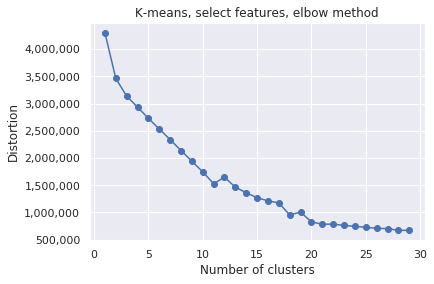

In [27]:
model_name = "K-means, select features"
model_code = 'km_sf'
k_min = 1
k_max = 30
distortions = []
t = time()
for i in range(k_min, k_max):
    km_sf = KMeans(n_clusters=i,
                   init='random',
                   n_init=10,
                   max_iter=300,
                   random_state=random_state,
                   n_jobs=12)
    km_sf.fit(X_sf_std)
    distortions.append(km_sf.inertia_)

elapsed = time() - t
f, ax = plt.subplots(1)
plt.plot(range(k_min, k_max), distortions, marker='o')
ax.set_title("{0}, elbow method".format(model_name))
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Distortion')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
print("took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
# plt.show()
save_path = os.path.join(plot_save_path, '{0}_elbow.png'.format(model_code))
f.savefig(save_path, bbox_inches='tight')

took 124.87 seconds (2.08 minutes)


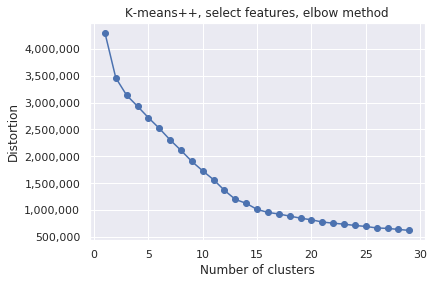

In [28]:
model_name = "K-means++, select features"
model_code = 'km_sf_p'
k_min = 1
k_max = 30
distortions = []
t = time()
for i in range(k_min, k_max):
    km_sf_p = KMeans(n_clusters=i,
                     init='k-means++',
                     n_init=10,
                     max_iter=300,
                     random_state=random_state,
                     n_jobs=12)
    km_sf_p.fit(X_sf_std)
    distortions.append(km_sf_p.inertia_)

elapsed = time() - t
f, ax = plt.subplots(1)
plt.plot(range(k_min, k_max), distortions, marker='o')
ax.set_title("{0}, elbow method".format(model_name))
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Distortion')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
print("took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
# plt.show()
save_path = os.path.join(plot_save_path, '{0}_elbow.png'.format(model_code))
f.savefig(save_path, bbox_inches='tight')

##### All features

took 237.20 seconds (3.95 minutes)


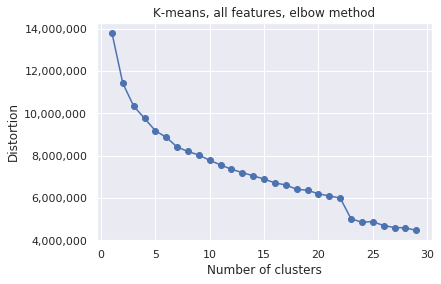

In [29]:
model_name = "K-means, all features"
model_code = 'km_af'
k_min = 1
k_max = 30
distortions = []
t = time()
for i in range(k_min, k_max):
    km_af = KMeans(n_clusters=i,
                   init='random',
                   n_init=10,
                   max_iter=300,
                   random_state=random_state,
                   n_jobs=12)
    km_af.fit(X_af_std)
    distortions.append(km_af.inertia_)

elapsed = time() - t
f, ax = plt.subplots(1)
plt.plot(range(k_min, k_max), distortions, marker='o')
ax.set_title("{0}, elbow method".format(model_name))
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Distortion')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
print("took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
# plt.show()
save_path = os.path.join(plot_save_path, '{0}_elbow.png'.format(model_code))
f.savefig(save_path, bbox_inches='tight')

took 322.38 seconds (5.37 minutes)


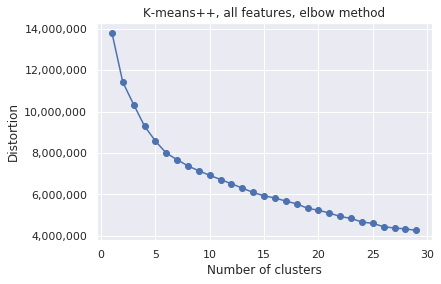

In [30]:
model_name = "K-means++, all features"
model_code = 'km_af_p'
k_min = 1
k_max = 30
distortions = []
t = time()
for i in range(k_min, k_max):
    km_af_p = KMeans(n_clusters=i,
                     init='k-means++',
                     n_init=10,
                     max_iter=300,
                     random_state=random_state,
                     n_jobs=12)
    km_af_p.fit(X_af_std)
    distortions.append(km_af_p.inertia_)

elapsed = time() - t
f, ax = plt.subplots(1)
plt.plot(range(k_min, k_max), distortions, marker='o')
ax.set_title("{0}, elbow method".format(model_name))
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Distortion')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
print("took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
# plt.show()
save_path = os.path.join(plot_save_path, '{0}_elbow.png'.format(model_code))
f.savefig(save_path, bbox_inches='tight')

#### Silhouette analysis
Silhouette analysis can be used as a graphical tool to plot a measure of how tightly grouped the samples in the clusters are by computing silhouette coefficients. 

Silhouette coefficients are computed for each sample in the dataset by first determining cluster cohesion of a sample $a^{(i)}$ (average distance between the sample $\boldsymbol{x}^{(i)}$ and all other points in the same cluster), cluster separation $b^{(i)}$ (average distance between the sample $\boldsymbol{x}^{(i)}$ and all samples in the nearest cluster. Then, silhouette $s^{(i)}$ can be computed as the difference between cluster cohesion and cluster separation, divided by the greater of the two:

$ \large{ s^{(i)} = \frac{ b^{(i)} - a^{(i)} } { \text{max} \left\{ b^{(i)}, a^{(i)} \right\} } } $

The silhouette coefficient is bounded in the range -1 to 1. Based on the preceding equation, we can see that the silhouette coefficient is 0 if the cluster separation and cohesion are equal ($b^{(i)} = a^{(i)}$). Furthermore, we get close to an ideal silhouette coefficient of 1 if $b^{(i)}>>a^{(i)}$, since $b^{(i)}$ quantifies how dissimilar a sample is to other clusters, and $a^{(i)}$ tells us how dissimilar it is to the other samples in its own cluster. Through a visual inspection of the silhouette plot, we can quickly scrutinize the sizes of the different clusters and identify clusters that contain outliers.

##### $k = 5$

In [28]:
from sklearn.cluster import KMeans
from time import time

def kmeans_silhouette_fit(X, k, model_name='K-means', 
                          km_init='k-means++', km_n_init=10, km_max_iter=300,
                          km_tol=1e-04, random_state=random_state, n_jobs=1):
    
    t = time()
    km = KMeans(n_clusters=k,
                init=km_init,
                n_init=km_n_init,
                max_iter=km_max_iter,
                tol=km_tol,
                random_state=random_state,
                n_jobs=n_jobs)
    y_pred = km.fit_predict(X)

    cluster_labels = np.unique(y_pred)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_pred, metric='euclidean')

    elapsed = time() - t
    print("{0} model fit, took {1:,.2f} seconds ({2:,.2f} minutes)".format(model_name, elapsed, elapsed / 60))
    return y_pred, n_clusters, cluster_labels, silhouette_vals

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import silhouette_samples
from time import time

def kmeans_silhouette_plot(cluster_labels, y_pred, n_clusters, model_name, model_code, 
                           fig_width=8, fig_height=10, output='show'):
    t = time()
    f, ax = plt.subplots(1, figsize=(fig_width, fig_height))

    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_pred == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                 c_silhouette_vals, 
                 height=1.0,
                 edgecolor='none',
                 color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
 
    silhouette_avg = np.mean(silhouette_vals)

    ax.axvline(silhouette_avg,
               color="red",
               linestyle="--") 
    plt.yticks(yticks, cluster_labels + 1)
    ax.set_ylabel('Cluster')
    ax.set_xlabel('Silhouette coefficient')
    ax.set_title("{0}, plot of silhouette coefficients".format(model_name))
    elapsed = time() - t
    if output == 'show':
        plt.show()
        print("Plotting finished, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
    elif output == 'save':
        save_path = os.path.join(plot_save_path, '{0}_silhouette.png'.format(model_code))
        f.savefig(save_path, bbox_inches='tight')
        plt.close(f)
        print("Plot saved, took {0:,.2f} seconds ({1:,.2f} minutes)".format(elapsed, elapsed / 60))
    else:
        raise ValueError("Input parameter 'output' must be either 'save' or 'show'")

In [34]:
tt = time()
k_min = 5
k_max = 15
print("------ Plotting silhouette coefficients, {0:,.0f} plots in total".format(k_max - k_min))

for k in range(k_min, k_max + 1):
    model_name = "K-means++ (k={0}, select features)".format(k)
    model_code = 'km_sf_p_k{0}'.format(k)
    y_pred, n_clusters, cluster_labels, silhouette_vals = \
                            kmeans_silhouette_fit(X_sf_std, k, model_name=model_name, n_jobs=12)
    kmeans_silhouette_plot(cluster_labels, y_pred, n_clusters, model_name, model_code, output='save')

t_elapsed = time() - t
print("------ Finished all plots, total time: {0:,.2f} seconds ({1:,.2f} minutes, {2:,.2f} hours)"
      .format(t_elapsed, t_elapsed / 60, t_elapsed / 3600))

------ Plotting silhouette coefficients, 25 plots in total
K-means++ (k=5, select features) model fit, took 885.47 seconds (14.76 minutes)
Plot saved, took 257.17 seconds (4.29 minutes)
K-means++ (k=6, select features) model fit, took 871.03 seconds (14.52 minutes)
Plot saved, took 211.79 seconds (3.53 minutes)
K-means++ (k=7, select features) model fit, took 894.53 seconds (14.91 minutes)
Plot saved, took 195.89 seconds (3.26 minutes)
K-means++ (k=8, select features) model fit, took 842.95 seconds (14.05 minutes)
Plot saved, took 232.31 seconds (3.87 minutes)
K-means++ (k=9, select features) model fit, took 902.36 seconds (15.04 minutes)
Plot saved, took 216.09 seconds (3.60 minutes)
K-means++ (k=10, select features) model fit, took 856.01 seconds (14.27 minutes)
Plot saved, took 222.35 seconds (3.71 minutes)
K-means++ (k=11, select features) model fit, took 858.58 seconds (14.31 minutes)
Plot saved, took 177.99 seconds (2.97 minutes)
K-means++ (k=12, select features) model fit, took 

OSError: [Errno 12] Cannot allocate memory

In [30]:
tt = time()
k_min = 15
k_max = 30
print("------ Plotting silhouette coefficients, {0:,.0f} plots in total".format(k_max - k_min))

for k in range(k_min, k_max + 1):
    model_name = "K-means++ (k={0}, select features)".format(k)
    model_code = 'km_sf_p_k{0}'.format(k)
    y_pred, n_clusters, cluster_labels, silhouette_vals = \
                            kmeans_silhouette_fit(X_sf_std, k, model_name=model_name, n_jobs=12)
    kmeans_silhouette_plot(cluster_labels, y_pred, n_clusters, model_name, model_code, output='save')

t_elapsed = time() - t
print("------ Finished all plots, total time: {0:,.2f} seconds ({1:,.2f} minutes, {2:,.2f} hours)"
      .format(t_elapsed, t_elapsed / 60, t_elapsed / 3600))

------ Plotting silhouette coefficients, 12 plots in total
K-means++ (k=18, select features) model fit, took 918.13 seconds (15.30 minutes)
Plot saved, took 195.79 seconds (3.26 minutes)
K-means++ (k=19, select features) model fit, took 844.38 seconds (14.07 minutes)
Plot saved, took 208.46 seconds (3.47 minutes)
K-means++ (k=20, select features) model fit, took 869.65 seconds (14.49 minutes)
Plot saved, took 196.66 seconds (3.28 minutes)
K-means++ (k=21, select features) model fit, took 863.60 seconds (14.39 minutes)
Plot saved, took 234.01 seconds (3.90 minutes)
K-means++ (k=22, select features) model fit, took 954.70 seconds (15.91 minutes)
Plot saved, took 216.54 seconds (3.61 minutes)
K-means++ (k=23, select features) model fit, took 962.26 seconds (16.04 minutes)
Plot saved, took 225.58 seconds (3.76 minutes)
K-means++ (k=24, select features) model fit, took 931.84 seconds (15.53 minutes)
Plot saved, took 180.40 seconds (3.01 minutes)
K-means++ (k=25, select features) model fit, 

In [32]:
tt = time()
k_min = 5
k_max = 15
print("------ Plotting silhouette coefficients, {0:,.0f} plots in total".format(k_max - k_min))

for k in range(k_min, k_max + 1):
    model_name = "K-means++ (k={0}, all features)".format(k)
    model_code = 'km_af_p_k{0}'.format(k)
    y_pred, n_clusters, cluster_labels, silhouette_vals = \
                            kmeans_silhouette_fit(X_af_std, k, model_name=model_name, n_jobs=12)
    kmeans_silhouette_plot(cluster_labels, y_pred, n_clusters, model_name, model_code, output='save')

t_elapsed = time() - t
print("------ Finished all plots, total time: {0:,.2f} seconds ({1:,.2f} minutes, {2:,.2f} hours)"
      .format(t_elapsed, t_elapsed / 60, t_elapsed / 3600))

------ Plotting silhouette coefficients, 10 plots in total
K-means++ (k=5, all features) model fit, took 998.52 seconds (16.64 minutes)
Plot saved, took 192.33 seconds (3.21 minutes)
K-means++ (k=6, all features) model fit, took 930.53 seconds (15.51 minutes)
Plot saved, took 205.82 seconds (3.43 minutes)
K-means++ (k=7, all features) model fit, took 954.82 seconds (15.91 minutes)
Plot saved, took 195.42 seconds (3.26 minutes)
K-means++ (k=8, all features) model fit, took 936.28 seconds (15.60 minutes)
Plot saved, took 229.36 seconds (3.82 minutes)
K-means++ (k=9, all features) model fit, took 978.43 seconds (16.31 minutes)
Plot saved, took 213.46 seconds (3.56 minutes)
K-means++ (k=10, all features) model fit, took 931.58 seconds (15.53 minutes)
Plot saved, took 217.91 seconds (3.63 minutes)
K-means++ (k=11, all features) model fit, took 931.62 seconds (15.53 minutes)
Plot saved, took 175.53 seconds (2.93 minutes)
K-means++ (k=12, all features) model fit, took 918.41 seconds (15.31 mi

In [30]:
tt = time()
k_min = 15
k_max = 30
print("------ Plotting silhouette coefficients, {0:,.0f} plots in total".format(k_max - k_min))

for k in range(k_min, k_max + 1):
    model_name = "K-means++ (k={0}, all features)".format(k)
    model_code = 'km_af_p_k{0}'.format(k)
    y_pred, n_clusters, cluster_labels, silhouette_vals = \
                            kmeans_silhouette_fit(X_af_std, k, model_name=model_name, n_jobs=12)
    kmeans_silhouette_plot(cluster_labels, y_pred, n_clusters, model_name, model_code, output='save')

t_elapsed = time() - t
print("------ Finished all plots, total time: {0:,.2f} seconds ({1:,.2f} minutes, {2:,.2f} hours)"
      .format(t_elapsed, t_elapsed / 60, t_elapsed / 3600))

------ Plotting silhouette coefficients, 15 plots in total
K-means++ (k=15, all features) model fit, took 959.38 seconds (15.99 minutes)
Plot saved, took 198.49 seconds (3.31 minutes)
K-means++ (k=16, all features) model fit, took 953.31 seconds (15.89 minutes)
Plot saved, took 209.81 seconds (3.50 minutes)
K-means++ (k=17, all features) model fit, took 925.72 seconds (15.43 minutes)
Plot saved, took 192.82 seconds (3.21 minutes)
K-means++ (k=18, all features) model fit, took 910.15 seconds (15.17 minutes)
Plot saved, took 230.60 seconds (3.84 minutes)
K-means++ (k=19, all features) model fit, took 961.96 seconds (16.03 minutes)
Plot saved, took 213.00 seconds (3.55 minutes)
K-means++ (k=20, all features) model fit, took 929.37 seconds (15.49 minutes)
Plot saved, took 221.89 seconds (3.70 minutes)
K-means++ (k=21, all features) model fit, took 933.24 seconds (15.55 minutes)
Plot saved, took 176.67 seconds (2.94 minutes)
K-means++ (k=22, all features) model fit, took 931.65 seconds (15.

OSError: [Errno 12] Cannot allocate memory

## DBSCAN
DBSCAN represents one of the alternatives to prototype-based clustering: density-based clustering.

Density-based Spatial Clustering of Applications with Noise (DBSCAN) does not make assumptions about spherical clusters like $k$-means, nor does it partition the dataset into hierarchies that require a manual cut-off point. As its name implies, density-based clustering assigns cluster labels based on dense regions of points. In DBSCAN, the notion of density is defined as the number of points within a specified radius $\large{ \varepsilon }$.

According to the DBSCAN algorithm, a special label is assigned to each sample (point) using the following criteria: a point is considered a core point if at least a specified number (MinPts) of neighboring points fall within the specified radius; a border point is a point that has fewer neighbors than MinPts within , but lies within the  radius of a core point; all other points that are neither core nor border points are considered noise points.

After labeling the points as core, border, or noise, the DBSCAN algorithm forms a separate cluster for each core point or connected group of core points (core points are connected if they are no farther away than $\large{ \varepsilon }$). Then, each border point is assigned to the cluster of its corresponding core point. DBSCAN is different from $k$-means and hierarchical clustering in that it doesn't necessarily assign each point to a cluster but is capable of removing noise points.

However, DBSCAN algorithm also has some disadvantages. With an increasing number of features in our dataset—assuming a fixed number of training examples—the negative effect of the curse of dimensionality increases. This is especially a problem if we are using the Euclidean distance metric. However, the problem of the curse of dimensionality is not unique to DBSCAN; it also affects other clustering algorithms that use the Euclidean distance metric, for example, $k$-means and hierarchical clustering algorithms. In addition, we have two hyperparameters in DBSCAN (MinPts and $\large{\varepsilon}$) that need to be optimized to yield good clustering results. Finding a good combination of MinPts and  can be problematic if the density differences in the dataset are relatively large.

In [27]:
eps = 0.2
min_samples = 100
model_name = 'DBSCAN (eps={0}, min_samples={1}), select features'.format(eps, min_samples)
t = time()
db = DBSCAN(eps=eps,
            min_samples=min_samples,
            metric='euclidean',
            n_jobs=12)
y_db_sf = db.fit_predict(X_sf_std)
elapsed = time() - t
print("{0} model fit, took {1:,.2f} seconds ({2:,.2f} minutes)"
      .format(model_name, elapsed, elapsed / 60))

DBSCAN (eps=0.2, min_samples=100), select features model fit, took 101.27 seconds (1.69 minutes)


In [28]:
eps = 0.2
min_samples = 100
model_name = 'DBSCAN (eps={0}, min_samples={1}), all features'.format(eps, min_samples)
t = time()
db = DBSCAN(eps=eps,
            min_samples=min_samples,
            metric='euclidean',
            n_jobs=12)
y_db_af = db.fit_predict(X_af_std)
elapsed = time() - t
print("{0} model fit, took {1:,.2f} seconds ({2:,.2f} minutes)"
      .format(model_name, elapsed, elapsed / 60))

DBSCAN (eps=0.2, min_samples=100), all features model fit, took 103.96 seconds (1.73 minutes)


## Apply $k$-means clustering algorithm

### Selected features

In [ ]:
k = 15
km_sf = KMeans(n_clusters=k, 
               init='random', 
               n_init=10,
               max_iter=300, 
               tol=1e-04,
               random_state=random_state,
               n_jobs=12)
t = time()
y_km_sf = km_sf.fit_predict(X_sf_std)
elapsed = time() - t
print("K-means model fit (k={0}), took {1:,.2f} seconds ({2:,.2f} minutes)"
      .format(k, elapsed, elapsed / 60))

In [ ]:
k = 15
km_sf_p = KMeans(n_clusters=k, 
                 init='k-means++', 
                 n_init=10,
                 max_iter=300, 
                 tol=1e-04,
                 random_state=random_state,
                 n_jobs=12)
t = time()
y_km_sf_p = km_sf_p.fit_predict(X_sf_std)
elapsed = time() - t
print("K-means++ model fit (k={0}), took {1:,.2f} seconds ({2:,.2f} minutes)"
      .format(k, elapsed, elapsed / 60))

### All features

In [ ]:
k = 15
km_af = KMeans(n_clusters=k, 
               init='random', 
               n_init=10,
               max_iter=300, 
               tol=1e-04,
               random_state=random_state,
               n_jobs=12)
t = time()
y_km_af = km_af.fit_predict(X_af_std)
elapsed = time() - t
print("K-Means model fit (k={0}), took {1:,.2f} seconds ({2:,.2f} minutes)"
      .format(k, elapsed, elapsed / 60))

In [ ]:
k = 15
km_af_p = KMeans(n_clusters=k, 
                 init='k-means++', 
                 n_init=10,
                 max_iter=300, 
                 tol=1e-04,
                 random_state=random_state,
                 n_jobs=12)
t = time()
y_km_af_p = km_af_p.fit_predict(X_af_std)
elapsed = time() - t
print("K-Means++ model fit (k={0}), took {1:,.2f} seconds ({2:,.2f} minutes)"
      .format(k, elapsed, elapsed / 60))

## Interpret results of clustering

### Count of samples by cluster

In [ ]:
np.bincount(y_km_sf)

In [ ]:
np.bincount(y_km_sf_p)

In [ ]:
np.bincount(y_km_af)

In [ ]:
np.bincount(y_km_af_p)

### Distortion (within-cluster SSE)

In [ ]:
print("Distortion: {0:,.2f}".format(km_sf.inertia_))

In [ ]:
print("Distortion: {0:,.2f}".format(km_sf_p.inertia_))

In [ ]:
print("Distortion: {0:,.2f}".format(km_af.inertia_))

In [ ]:
print("Distortion: {0:,.2f}".format(km_af_p.inertia_))

## Hierarchical clustering
Hierarchical clustering is another alternative to prototype-based clustering. 

The two main approaches to hierarchical clustering are agglomerative and divisive hierarchical clustering. In divisive hierarchical clustering, we start with one cluster that encompasses all our samples, and we iteratively split the cluster into smaller clusters until each cluster only contains one sample. Agglomerative clustering takes the opposite approach: we start with each sample as an individual cluster and merge the closest pairs of clusters until only one cluster remains.

One advantage of hierarchical clustering algorithms is that it allows us to plot dendrograms (visualizations of a binary hierarchical clustering), which can help with the interpretation of the results by creating meaningful taxonomies. Another useful advantage of this hierarchical approach is that it can be fit without specifying the number of clusters up front. `AgglomerativeClustering` implementation in scikit-learn allows us to choose the number of clusters that we want to return, which is useful if we want to prune the hierarchical cluster tree.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

k = 15
model_name = 'Agglomerative clustering'
t = time()
ac = AgglomerativeClustering(n_clusters=k,
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X_sf_std)
elapsed = time() - t
print("{0} model fit, took {1:,.2f} seconds ({2:,.2f} minutes)"
      .format(model_name, elapsed, elapsed / 60))